# Лабораторная работа 1. Pandas, метод ближайших соседей и решающие деревья.

Масляков Глеб Олегович

Группа №317

## Часть 1: Pandas

In [3]:
import numpy as np
import pandas as pd

Ответьте на вопросы о данных по авиарейсам в США.

Данные: http://stat-computing.org/dataexpo/2009/2008.csv.bz2 (обратите внимание, что распаковывать этот файл не обязательно — функция pandas.read_csv умеет читать из архивов автоматически)
Описание: http://stat-computing.org/dataexpo/2009/the-data.html

Какая из причин отмены рейса (CancellationCode) была самой частой? (расшифровки кодов можно найти в описании данных)
Найдите среднее, минимальное и максимальное расстояние, пройденное самолетом.

Не выглядит ли подозрительным минимальное пройденное расстояние? В какие дни и на каких рейсах оно было? Какое расстояние было пройдено этими же рейсами в другие дни?

Из какого аэропорта было произведено больше всего вылетов? В каком городе он находится?
Найдите для каждого аэропорта среднее время полета (AirTime) по всем вылетевшим из него рейсам. Какой аэропорт имеет наибольшее значение этого показателя?

Найдите аэропорт, у которого наибольшая доля задержанных (DepDelay > 0) рейсов. Исключите при этом из рассмотрения аэропорты, из которых было отправлено меньше 1000 рейсов (используйте функцию filter после groupby).

In [3]:
df = pd.read_csv("/Users/admin/Downloads/2008.csv.bz2")

In [4]:
CC = df.CancellationCode.value_counts()

In [7]:
CC.argmax()

'B'

Самая частая причина отмены рейса - это погода! 

In [8]:
df["Distance"].max()

4962

Максимальная длина полёта - 4962 мили! 

In [9]:
df["Distance"].min()

11

Минимальная длина полёта - 11 миль!

На самом деле там просто два аэропорта рядом, и, видимо, там делали пересадку.

In [4]:
df["Distance"].mean()

726.3870294253928

Средняя длина полёта ~ 726.3870294253928 мили!

In [11]:
df[df.Distance == 11][["Year", "Month", "DayofMonth", "FlightNum"]]

,Year,Month,DayofMonth,FlightNum
2547298,2008,5,15,4988
4392215,2008,8,10,5572


Самый короткий рейс происходит нечасто.

In [12]:
df[df.FlightNum == 4988]["Distance"].unique()

array([834,  96,  11, 414, 223, 712, 321, 903])

In [13]:
df[df.FlightNum == 5572]["Distance"].unique()

array([544, 329,  11, 363, 134, 669, 508])

In [18]:
df["Origin"].value_counts().argmax()

'ATL'

Это аэропорт Хартсфилд-Джексон Атланта!

В другие дни ничего подобного не наблюдалось.

In [20]:
df[df.Origin == 'ATL'].AirTime.mean()

93.32041864013088

In [22]:
airport = df["Origin"].unique()

In [27]:
mean_time = df.groupby("Origin").AirTime.mean()

In [30]:
mean_time.argmax()

'SJU'

А это аэропорт Каролины!

In [11]:
delay = pd.concat([df['Origin'], (df['DepDelay']>0).astype(int)], axis=1)
g = delay.groupby('Origin').filter(lambda x: len(x) > 1000)
m_del = g.groupby('Origin').mean()
m_del.loc[m_del['DepDelay'] == m_del['DepDelay'].max()].T

Origin,DAL
DepDelay,0.578642


Аэропорт - Даллас Love Field

## Часть 2: метрические методы и категориальные признаки

Все дальнейшие эксперименты предлагается проводить на данных соревнования Amazon Employee Access Challenge: https://www.kaggle.com/c/amazon-employee-access-challenge
В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.
Для удобства данные можно загрузить по ссылке: https://www.dropbox.com/s/q6fbs1vvhd5kvek/amazon.csv
Сразу прочитаем данные и создадим разбиение на обучение и контроль:

In [33]:
data = pd.read_csv('/Users/admin/Downloads/amazon.csv')
data.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [34]:
data.shape

(32769, 10)

In [35]:
# доля положительных примеров
data.ACTION.mean()

0.9421099209618847

In [37]:
# число значений у признаков
for col_name in data.columns:
    print(col_name, len(data[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [38]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241)

#### 1. Реализуйте три функции расстояния на категориальных признаках, которые обсуждались на втором семинаре.

Проще всего будет определить метрики как user-defined distance, после чего воспользоваться реализацией kNN из sklearn (в этом случае используйте функцию predict_proba). Можно реализовать метод k ближайших соседей и самостоятально — в этом случае учитите, что он должен возвращать оценку вероятности, то есть отношение объектов первого класса среди соседей к числу соседей).
Постарайтесь уделить особое внимание эффективности кода — при реализации метрик "в лоб" вы можете столкнуться с очень большим временем выполнения.

Подсчитайте для каждой из метрик качество на тестовой выборке X_test при числе соседей $k = 10$. Мера качества — AUC-ROC.

Какая функция расстояния оказалась лучшей?

In [82]:
from sklearn.neighbors import KNeighborsClassifier

In [83]:
from sklearn.cross_validation import KFold, cross_val_score

In [127]:
from sklearn import metrics

In [74]:
X = X_train.values

In [75]:
X

array([[ 40867,   8150, 117961, ..., 118054, 117887, 118055],
       [ 38587,  14551,   5110, ..., 117897,  19721, 117900],
       [  3853,  51301, 118290, ..., 118302, 118295, 126870],
       ..., 
       [ 32270,  61062, 117961, ..., 303111, 118638, 119851],
       [ 79299,  55667, 117902, ..., 130913, 292795, 119082],
       [   691,   2983, 117961, ..., 117906, 290919, 118322]])

In [77]:
y = y_train.values

In [78]:
y

array([1, 1, 1, ..., 1, 1, 1])

In [79]:
test_sample = X_test.values

In [80]:
test_ans = y_test.values

Первая функция -  индикатор совпадения.

In [110]:
def coin_indicator(x, y):
    return np.sum((x - y) != 0, axis=0)

Функции для обеспечения эффективной работы двух оставшихся метрик. Без них всё очень медленно.

Эта создаёт список (по столбцам) из словарей частот, с которыми встречаются признаки. Ключ - значение признака. Значение - частота.

In [229]:
def create_list(X):
    lst = []
    for i in range(X.shape[1]):
        lst.append({})
    chast = np.zeros(X.shape, dtype=int)
    uniq = np.unique(X)
    uniq = uniq.reshape(1, uniq.shape[0])
    chast_unique = np.zeros(uniq.shape[1], dtype=int)
    for j in range(X.shape[1]):
        for i in range(X.shape[0]):
            chast_unique[(uniq == X[i, j]).any(axis=0)] += 1
        for i in range(X.shape[0]):
            chast[i, j] += chast_unique[(uniq == X[i, j]).any(axis=0)]
        chast_unique = np.zeros(uniq.shape[1], dtype=int)
    for j in range(X.shape[1]):
        for i in range(X.shape[0]):
            lst[j][X[i, j]] = chast[i, j]
    return lst

Тоже самое, только для положительных объектов.

In [230]:
def create_pos_list(X, y):
    lst = []
    for i in range(X.shape[1]):
        lst.append({})
    chast = np.zeros(X.shape, dtype=int)
    uniq = np.unique(X)
    uniq = uniq.reshape(1, uniq.shape[0])
    chast_unique = np.zeros(uniq.shape[1], dtype=int)
    for j in range(X.shape[1]):
        for i in range(X.shape[0]):
            if y[i]:
                chast_unique[(uniq == X[i, j]).any(axis=0)] += 1
        for i in range(X.shape[0]):
            chast[i, j] += chast_unique[(uniq == X[i, j]).any(axis=0)]
        chast_unique = np.zeros(uniq.shape[1], dtype=int)
    for j in range(X.shape[1]):
        for i in range(X.shape[0]):
            lst[j][X[i, j]] = chast[i, j]
    return lst

Создаёт матрицу частот.

In [231]:
def create_chast(X):
    chast = np.zeros(X.shape, dtype=int)
    uniq = np.unique(X)
    uniq = uniq.reshape(1, uniq.shape[0])
    chast_unique = np.zeros(uniq.shape[1], dtype=int)
    for j in range(X.shape[1]):
        for i in range(X.shape[0]):
            chast_unique[(uniq == X[i, j]).any(axis=0)] += 1
        for i in range(X.shape[0]):
            chast[i, j] += chast_unique[(uniq == X[i, j]).any(axis=0)]
        chast_unique = np.zeros(uniq.shape[1], dtype=int)
    return chast

In [409]:
lst = create_list(X)
pos_lst = create_pos_list(X, y)
chast = create_chast(X)

In [244]:
l = X.shape[0]

Сглаженный индикатор расстояния.

In [397]:
def coin_indicator_2(x, y):
    res = np.sum(np.not_equal(x, y), axis=0)
    ch_y = np.zeros(y.shape[0])
    for i in range(ch_y.shape[0]):
        ch_y[i] = lst[i][y[i]]
    s = 0.0
    for i in range(y.shape[0]):
        if x[i] == y[i]:
            p = np.array(list(lst[i].values()))
            s += np.sum((p[p <= y[i]])*(p[p <= y[i]] - 1)/(l*(l-1)))
    return res + s

Третья метрика. Не знал как называется, поэтому назвал по аналогии с другими.

In [413]:
def coin_indicator_3(x, y):
    ch_x = np.zeros(x.shape[0])
    ch_y = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        if x[i] in lst[i]:
            ch_x[i] = lst[i][x[i]]
    for i in range(x.shape[0]):
        ch_y[i] = lst[i][y[i]]
    return np.sum(np.not_equal(x, y) * np.log(ch_x + 1) * np.log(ch_y + 1), axis=0)

Считаем для второй метрики.

In [417]:
nei = KNeighborsClassifier(n_neighbors=k, algorithm="brute", metric=coin_indicator_2)
nei.fit(X, y)
predict = nei.predict_proba(test_sample)
finish = time.clock() - start
arg = predict[:,1].argsort()
fpr, tpr, thresholds = metrics.roc_curve(test_ans[arg], predict[arg, 1], pos_label=1)
score = metrics.auc(fpr, tpr)

In [418]:
print(score)

0.822127712111


Считаем для третьей метрики.

In [419]:
start = time.clock()
nei = KNeighborsClassifier(n_neighbors=k, algorithm="brute", metric=coin_indicator_3)
nei.fit(X, y)
predict = nei.predict_proba(test_sample)
finish = time.clock() - start
arg = predict[:,1].argsort()
fpr, tpr, thresholds = metrics.roc_curve(test_ans[arg], predict[arg, 1], pos_label=1)
score = metrics.auc(fpr, tpr)

In [420]:
print(score)

0.805996566798


Считаем для первой метрики.

In [198]:
nei = KNeighborsClassifier(n_neighbors=10, algorithm="brute", metric=coin_indicator)

In [199]:
nei.fit(X, y)

KNeighborsClassifier(algorithm='brute', leaf_size=30,
           metric=<function coin_indicator at 0x1140539d8>,
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [200]:
predict = nei.predict_proba(test_sample)

In [139]:
arg = predict[:,1].argsort()

In [147]:
fpr, tpr, thresholds = metrics.roc_curve(test_ans[arg], predict[arg, 1], pos_label=1)

In [148]:
metrics.auc(fpr, tpr)

0.829499015542142

В итоге, самый лучший результат, с точностью 82.9499% (почти 83%) показал индикатор совпадения. На втором месте сглаженный индикатор, на третьем неизвестная метрика.

### 3. Реализуйте счетчики (http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx), которые заменят категориальные признаки на вещественные.

А именно, каждый категориальный признак нужно заменить на три:
Число counts объектов в обучающей выборке с таким же значением признака.
Число successes объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
Сглаженное отношение двух предыдущих величин: (successes + 1) / (counts + 2).
Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать фолдинг: разбить обучающую выборку на $n$ частей, и для $i$-й части считать counts и successes по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

#### Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

Функция счётчиков.

In [292]:
def counts(X, y, arr):
    lst = create_list(X)
    pos_lst = create_pos_list(X, y)
    new = np.zeros((arr.shape[0], arr.shape[1] * 3))
    for j in range(arr.shape[1]):
        for i in range(arr.shape[0]):
            if arr[i, j] in lst[j]:
                new[i, j] = lst[j][arr[i, j]]
                if arr[i, j] in pos_lst[j]:
                    new[i, j + arr.shape[1]] = pos_lst[j][arr[i, j]]
                new[i, j + 2 * arr.shape[1]] = (new[i, j + arr.shape[1]] + 1) / (new[i, j] + 2)
    return new

In [381]:
count_sample = counts(X, y, X)
count_test = counts(X, y, test_sample)

Находим оптимальное число соседей без фолдинга.

In [383]:
max_score = 0
best_k = 0
for k in range(1, 21):
    nei = KNeighborsClassifier(n_neighbors=k, algorithm="brute", metric='euclidean')
    nei.fit(count_sample, y)
    predict = nei.predict_proba(count_test)
    arg = predict[:,1].argsort()
    fpr, tpr, thresholds = metrics.roc_curve(test_ans[arg], predict[arg, 1], pos_label=1)
    score = metrics.auc(fpr, tpr)
    if score > max_score:
        max_score = score
        best_k = k

In [384]:
print(max_score)
print(best_k)

0.796083338545
14


Наилучший результат 79.6% достигается при 14 соседях.

Теперь с фолдингом.

In [385]:
f_size = int(X.shape[0] / 3)
count_samp_fol = counts(X[f_size:], y[f_size:], X[:f_size])
count_samp_fol = np.vstack((count_samp_fol,
                     counts(np.vstack((X[:f_size], X[2*f_size:])), np.hstack((y[:f_size], y[2*f_size:])), X[f_size:2*f_size])))
count_samp_fol = np.vstack((count_samp_fol, counts(X[:2*f_size], y[:2*f_size], X[2*f_size:])))

In [387]:
max_score = 0
best_k = 0
for k in range(1, 21):
    nei = KNeighborsClassifier(n_neighbors=k, algorithm="brute", metric='euclidean')
    nei.fit(count_samp_fol, y)
    predict = nei.predict_proba(count_test)
    arg = predict[:,1].argsort()
    fpr, tpr, thresholds = metrics.roc_curve(test_ans[arg], predict[arg, 1], pos_label=1)
    score = metrics.auc(fpr, tpr)
    if score > max_score:
        max_score = score
        best_k = k

In [388]:
print(max_score)
print(best_k)

0.57500354031
14


Наилучший результат также при 14 соседях, но на этот раз 57.5%. Видимо фолдинги переобучают модель?  

#### 4. Добавьте в исходную выборку парные признаки — то есть для каждой пары $(f_i, f_j)$, $i &lt; j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$ (желательно через какой-нибудь специальный символ во избежание коллизий). Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [340]:
pair_sample = np.zeros((X.shape[0], 36), dtype='<U20')
for p in range(X.shape[0]):
    col = 0
    for i in range(1, X.shape[1]):
        for j in range(i):
            pair_sample[p, col] = str(X[p, j])+"$"+str(X[p, i])
            col += 1

In [343]:
pair_test = np.zeros((test_sample.shape[0], 36), dtype='<U20')
for p in range(test_sample.shape[0]):
    col = 0
    for i in range(1, test_sample.shape[1]):
        for j in range(i):
            pair_test[p, col] = str(test_sample[p, j])+"$"+str(test_sample[p, i])
            col += 1

Без фолдинга.

In [344]:
new_test = counts(pair_sample, y, pair_test)

In [346]:
new_sample = counts(pair_sample, y, pair_sample)

In [354]:
max_score = 0
max_nei = 0
for k in range(1, 21):
    nei = KNeighborsClassifier(n_neighbors=k, algorithm="brute", metric='euclidean')
    nei.fit(new_sample, y)
    predict = nei.predict_proba(new_test)
    arg = predict[:,1].argsort()
    fpr, tpr, thresholds = metrics.roc_curve(test_ans[arg], predict[arg, 1], pos_label=1)
    score = metrics.auc(fpr, tpr)
    if score > max_score:
        max_nei = k
        max_score = score

In [355]:
print(max_nei)
print(max_score)

8
0.811110787631


Наилучший результат 81.111% при 8-ми соседях.

С фолдингом.

In [359]:
new_samp_fol = counts(pair_sample[f_size:], y[f_size:], pair_sample[:f_size])

In [361]:
new_samp_fol = np.vstack((new_samp_fol,
                     counts(np.vstack((pair_sample[:f_size], pair_sample[2*f_size:])), 
                            np.concatenate((y[:f_size], y[2*f_size:])),
                            pair_sample[f_size:2*f_size])))

In [364]:
new_samp_fol = np.vstack((new_samp_fol, counts(pair_sample[:2*f_size], y[:2*f_size], pair_sample[2*f_size:])))

In [389]:
max_score = 0
max_nei = 0
for k in range(1, 21):
    nei = KNeighborsClassifier(n_neighbors=k, algorithm="brute", metric='euclidean')
    nei.fit(new_samp_fol, y)
    predict = nei.predict_proba(new_test)
    arg = predict[:,1].argsort()
    fpr, tpr, thresholds = metrics.roc_curve(test_ans[arg], predict[arg, 1], pos_label=1)
    score = metrics.auc(fpr, tpr)
    if score > max_score:
        max_nei = k
        max_score = score

In [390]:
print(max_score)
print(max_nei)

0.579538462147
18


Как и в прошлый раз результат упал. Наверное, переобучение? Или влияет то, что тестовая выборка переводится на основании частотных характеристик обучающей, которые не актуальны для фолдов?

## Часть 3: Решающие деревья и леса

#### 1. Возьмите из предыдущей части выборку с парными признаками, преобразованную с помощью счетчиков без фолдинга. Настройте решающее дерево, подобрав оптимальные значения параметров max_depth и min_samples_leaf. Какой наилучший AUC-ROC на контроле удалось получить?

In [369]:
from sklearn import tree

In [438]:
max_score = 0
dep_leaf = [0, 0]
for i in [1,10,25,50,75,100]:
    for j in [1,10,20,30,50,100,200,300,500,1000,5000,10000,20000]:
        clf = tree.DecisionTreeClassifier(max_depth = i, min_samples_leaf = i)
        clf.fit(new_sample, y)
        predict = clf.predict_proba(new_test)
        arg = predict[:,1].argsort()
        fpr, tpr, thresholds = metrics.roc_curve(test_ans[arg], predict[arg, 1], pos_label=1)
        score = metrics.auc(fpr, tpr)
        if max_score < score:
            dep_leaf[0], dep_leaf[1] = i, j
            max_score = score

In [439]:
print(max_score)

0.580390472863


In [440]:
print(dep_leaf)

[50, 1000]


Не самый лучший результат. Всего лишь 58%. Видимо деревья по-одиночке действительно не очень.

#### 2. Настройте случайный лес, подобрав такое число деревьев n_estimators, при котором ошибка выходит на асимптоту. Какое качество на тестовой выборке он дает?

In [444]:
from sklearn import ensemble

In [446]:
max_score = 0
estim = 0
auc_lst = []
n_est = [1,10,20,30,40,50,100,200,300,400,500,1000,2000,3000,4000,5000,10000,15000,20000]
for i in n_est:
    rf = ensemble.RandomForestClassifier(n_estimators=i)
    rf.fit(new_sample, y)
    predict = rf.predict_proba(new_test)
    arg = predict[:,1].argsort()
    fpr, tpr, thresholds = metrics.roc_curve(test_ans[arg], predict[arg, 1], pos_label=1)
    score = metrics.auc(fpr, tpr)
    auc_lst.append(score)

In [454]:
print(auc_lst)

[0.54261688954447529, 0.55918239678647652, 0.6308563381618133, 0.64860425512949638, 0.69147175191805743, 0.63036015558675351, 0.71442527285548851, 0.70148031695301849, 0.68749609128177924, 0.69534767284801258, 0.70089832228828408, 0.70783310725666559, 0.70462634091498877, 0.7070580129262658, 0.70358473490084616, 0.70375959388148124, 0.70795953407359968, 0.7061812919221262, 0.70835166387395487]


In [450]:
print(max(auc_lst))

0.714425272855


In [7]:
%matplotlib inline
from matplotlib import pyplot

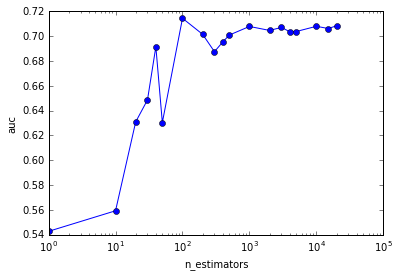

In [453]:
pyplot.plot(n_est, np.array(auc_lst), '-o', color='blue')
pyplot.xlabel('n_estimators')
pyplot.ylabel('auc')
pyplot.xscale('log')
pyplot.show()

Ну уже где-то на 1000 деревьев всё устаканивается.
Лучший результат - 71.44% при 100 деревьях.

#### 3. Возьмите выборку с парными признаками, для которой счетчики посчитаны с фолдингом. Обучите на ней случайный лес, подобрав число деревьев. Какое качество на тестовой выборке он дает? Чем вы можете объяснить изменение результата по сравнению с предыдущим пунктом?

In [455]:
auc_lst = []
n_est = [1,10,20,30,40,50,100,200,300,400,500,1000,2000,3000,4000,5000,10000,15000,20000]
for i in n_est:
    rf = ensemble.RandomForestClassifier(n_estimators=i)
    rf.fit(new_samp_fol, y)
    predict = rf.predict_proba(new_test)
    arg = predict[:,1].argsort()
    fpr, tpr, thresholds = metrics.roc_curve(test_ans[arg], predict[arg, 1], pos_label=1)
    score = metrics.auc(fpr, tpr)
    auc_lst.append(score)

In [456]:
print(max(auc_lst))

0.849145581154


In [482]:
print(auc_lst)

[0.64146172403407031, 0.80420520572976772, 0.82486875692337336, 0.82536682646585025, 0.83831573601433662, 0.83498146458863032, 0.83951683570300495, 0.84726373550539447, 0.84694995978063736, 0.84452242112655918, 0.84914558115361649, 0.84543993656914096, 0.84581005174963209, 0.84644919457042189, 0.84668991769946678, 0.8474703135097521, 0.84691958859078398, 0.84682820545445003, 0.84630821114770027]


Вот сейчас реально в ступоре. Самый лучший результат показала выборка с фолдингом, которая до этого не набирала и 0.6  по метрике качества AUC-ROC. Единственное объяснение, что преобразование выборки фолдами, делает её лучше разделяемой, чем сразу пользуются деревья.

Здесь вы можете поделиться своими мыслями о задании.

После странного результата со случайным лесом, мне сложно уже о чём-то писать и я не представляю как буду жить дальше. Ну и выбор о том, какую картинку вставлять стал самым сложным в моей жизни.

А здесь вставьте смешную картинку.

<img src = "image.png">

А здесь посоветуйте преподавателям хороший фильм или сериал.

Ну сериалы я почти не смотрю (из тех, что смотрел, больше всего понравился "Вавилон 5"), поэтому рекомендую фильм "Кабаре" 1988г.